<a href="https://colab.research.google.com/github/carla-garcia-medina/behavioral_cloning/blob/main/bc_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [127]:
!apt install xvfb

!pip install mpi4py
!pip install tensorflow==1.15.2
!pip install "gym==0.19.0"
!pip install pyvirtualdisplay
!apt update && apt install xvfb
!pip install gym-notebook-wrapper
!pip install stable_baselines

Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:

In [128]:
'''
Imports
'''
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import gnwrapper

import gym
from gym.wrappers import Monitor

import tensorflow_hub as hub

from stable_baselines.common.policies import MlpPolicy
from stable_baselines import PPO1

from stable_baselines.gail import generate_expert_traj

In [129]:
'''
Create Env and Train Expert
'''
env = gym.make('CartPole-v1')

ppo1_expert = PPO1(MlpPolicy, env, verbose=0)
ppo1_expert.learn(total_timesteps=250000)
ppo1_expert.save("ppo1_cartpole")
ppo1_expert = PPO1.load("ppo1_cartpole")

In [131]:
obs = env.reset()
state = None
expert_obs = np.array(obs)
expert_actions = np.array([[env.action_space.sample()]])
n_episodes = 1000

for _ in range(n_episodes):
  while True:
    expert_obs = np.vstack([expert_obs, obs])
    obs = torch.from_numpy(obs)
    action, next_state = ppo1_expert.predict(obs)
    expert_actions = np.vstack([expert_actions, np.array(action)])
    obs, rewards, done, info = env.step(action)
    if done: 
        break;

In [132]:
'''
Define BC Model as NN

Specs:
NN: 3 layers (4 each cells with ReLu) and Sigmoid on Output
Loss: BCE (Binary Cross Entropy)
'''
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
    	x = F.relu(self.fc1(x))
    	x = F.relu(self.fc2(x))
    	x = F.sigmoid(self.fc3(x))
    	return x

net = Net()
model = net

In [133]:
'''
Train BC Model
'''
criterion = nn.BCELoss()
learning_rate = [10, 1, 0.1, 0.01, 0.001, 0.0001]
#learning_rate that worke = [1.5]
for lr in learning_rate:
	x = torch.from_numpy(expert_obs).to(torch.float32)
	y = torch.from_numpy(expert_actions).to(torch.float32)
	for t in range(200):
		y_pred = model(x)
		loss = criterion(y_pred, y)
		print(t, loss.item())
		model.zero_grad()
		loss.backward()
		with torch.no_grad():
		    for param in model.parameters():
		      param.data -= lr * param.grad

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 0.6949477791786194
1 0.7066342830657959
2 0.7514063119888306
3 0.8974275588989258
4 0.9751019477844238
5 1.0209897756576538
6 1.0380940437316895
7 1.0428646802902222
8 1.044052004814148
9 1.0443378686904907
10 1.0444062948226929
11 1.0444225072860718
12 1.0444265604019165
13 1.0444273948669434
14 1.044427514076233
15 1.044427752494812
16 1.0444273948669434
17 1.0444276332855225
18 1.0444276332855225
19 1.044427752494812
20 1.044427514076233
21 1.0444276332855225
22 1.044427514076233
23 1.044427752494812
24 1.0444273948669434
25 1.0444276332855225
26 1.0444276332855225
27 1.044427752494812
28 1.044427514076233
29 1.0444276332855225
30 1.044427514076233
31 1.044427752494812
32 1.0444273948669434
33 1.0444276332855225
34 1.0444276332855225
35 1.044427752494812
36 1.044427514076233
37 1.0444276332855225
38 1.044427514076233
39 1.044427752494812
40 1.0444273948669434
41 1.0444276332855225
42 1.0444276332855225
43 1.044427752494812
44 1.044427514076233
45 1.0444276332855225
46 1.0444275140

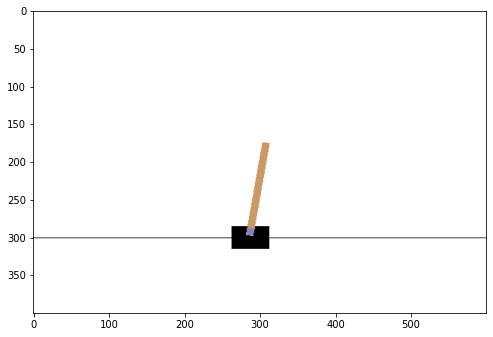

In [134]:
'''
Render BC Agent and Generate Gifs
'''
env = gnwrapper.LoopAnimation(gym.make('CartPole-v1')) # Start Xvfb

obs = env.reset()

while True:
  env.render()
  obs = torch.from_numpy(obs)
  model.double()
  action = model.forward(obs)
  if action < 0.5:
    action = 0
  else:
    action = 1
  obs, rewards, done, info = env.step(action)
  if done: 
      break;

env.display()